# Анализ данных осень 2021
# Работа с текстом

## План лекции

- Пара слов о прошлой лекции
- Пара слов о лекции про эмбеддинги
- Классические алгоритмы обработки текста
- Современные алгоритмы обработки текста
- Эмбеддинг текста
- Польза в анализе данных

## Проекция картинок с прошлой лекции

Классические датасеты разных модальностей на [projector.tensorflow.org](https://projector.tensorflow.org/)

Umap на картинках CIFAR10 в [tensorboard](http://localhost:6006/#projector) (umap не тянет картинки)

## Эмбеддинги текста

Разбирали на 9 лекции. Вспомним основные выводы:

- one-hot encoding слов слишком ресурсоёмкий
- ручная разметка невозможна
- контекст определяет слово
- модели обучения эмбеддингов: skip-gram, CBOW
- слова в линейном пространстве

## Что такое текст

Это набор слов. Если можем представить слово, то сумма представлений слов будет представлением текста

## Что можно делать с текстом

- классификация
- моделирование языка
- генерация
- перевод
- выделение эмоций
- ответы на вопросы, ведение диалога
- суммаризация
- поиск
- анализ

## Поиск и tf-idf

### Обзор данных

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
df = pd.read_csv('data/ag_news/train.csv')
df.columns = ['topic', 'title', 'description']
print(df.shape)
df.head(5)

(120000, 3)


,topic,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


<AxesSubplot:>

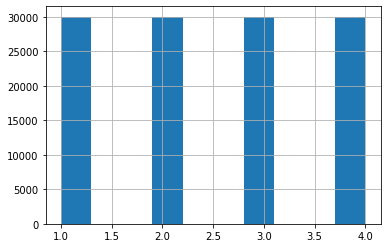

In [142]:
# Какое распределение топиков?
df.topic.hist()

<AxesSubplot:>

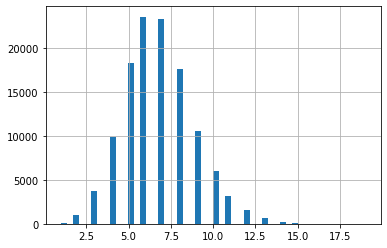

In [143]:
# Сколько слов в заголовках
words_n = df.title.apply(lambda text: len(text.split()))
words_n.hist(bins=50)

<AxesSubplot:>

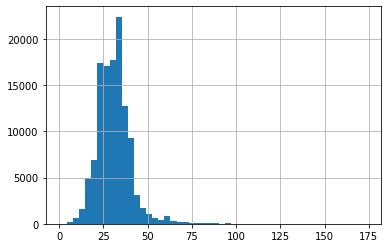

In [144]:
# Сколько слов в текстах
words_n = df.description.apply(lambda text: len(text.split()))
words_n.hist(bins=50)

### Словарь

In [145]:
# Не будем делить текст на заголовок и описание
df = df.assign(text=df.title + ' ' + df.description)

In [147]:
from itertools import chain

list(chain.from_iterable([[1,2,3], [4, 5], [6]]))

[1, 2, 3, 4, 5, 6]

In [148]:
from typing import List
from collections import Counter

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [149]:
texts = df.text.tolist()
vocab = build_vocab(texts)
print(len(vocab))
# слова разного регистра
list(vocab.items())[:30]

188091


[('Wall', 1290),
 ('St.', 1022),
 ('Bears', 265),
 ('Claw', 2),
 ('Back', 477),
 ('Into', 373),
 ('the', 177525),
 ('Black', 413),
 ('(Reuters)', 12798),
 ('Reuters', 4369),
 ('-', 39095),
 ('Short-sellers,', 2),
 ("Street's", 63),
 ('dwindling\\band', 1),
 ('of', 97390),
 ('ultra-cynics,', 2),
 ('are', 9297),
 ('seeing', 119),
 ('green', 185),
 ('again.', 213),
 ('Carlyle', 14),
 ('Looks', 106),
 ('Toward', 80),
 ('Commercial', 59),
 ('Aerospace', 35),
 ('Private', 109),
 ('investment', 633),
 ('firm', 1351),
 ('Group,\\which', 1),
 ('has', 18605)]

### Предобработка текста

#### фильтрация слов

In [150]:
# удалим спецсимволы

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    return text

texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
print(len(vocab))
# уже лучше. Но кажется есть очень частые слова
list(vocab.items())[:30]

91334


[('wall', 1394),
 ('st', 1643),
 ('bears', 399),
 ('claw', 17),
 ('back', 4122),
 ('into', 6635),
 ('the', 203581),
 ('black', 754),
 ('reuters', 17243),
 ('shortsellers', 2),
 ('streets', 303),
 ('dwindlingband', 1),
 ('of', 97947),
 ('ultracynics', 2),
 ('are', 9718),
 ('seeing', 135),
 ('green', 818),
 ('again', 1752),
 ('carlyle', 15),
 ('looks', 599),
 ('toward', 758),
 ('commercial', 488),
 ('aerospace', 124),
 ('private', 694),
 ('investment', 811),
 ('firm', 1730),
 ('groupwhich', 1),
 ('has', 18940),
 ('a', 107867),
 ('reputation', 117)]

In [151]:
# это "стоп-слова"
vocab.most_common(30)

[('the', 203581),
 ('to', 119158),
 ('a', 107867),
 ('of', 97947),
 ('in', 95475),
 ('and', 68878),
 ('on', 56514),
 ('for', 50240),
 ('s', 32084),
 ('that', 27746),
 ('with', 26662),
 ('as', 25220),
 ('at', 24893),
 ('its', 22711),
 ('is', 21983),
 ('new', 21220),
 ('by', 20721),
 ('said', 19995),
 ('us', 19742),
 ('it', 19469),
 ('has', 18940),
 ('from', 17700),
 ('reuters', 17243),
 ('an', 16831),
 ('ap', 16148),
 ('his', 14885),
 ('will', 14532),
 ('after', 14388),
 ('was', 13667),
 ('be', 11708)]

In [152]:
# natural language toolkit
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

eng_stopwords = stopwords.words('english')
print(len(eng_stopwords))
eng_stopwords[:30]

179


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i.shamov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself']

In [153]:
# удалим стоп-слова
eng_stopwords = set(eng_stopwords)

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
        
print(len(vocab))
# уже лучше. Но есть стоп-слова самого корпуса
vocab.most_common(30)

91183


[('new', 21220),
 ('said', 19995),
 ('us', 19742),
 ('reuters', 17243),
 ('ap', 16148),
 ('first', 9040),
 ('two', 8924),
 ('world', 7473),
 ('monday', 7448),
 ('wednesday', 7316),
 ('tuesday', 7251),
 ('oil', 7211),
 ('thursday', 7127),
 ('company', 7087),
 ('one', 7049),
 ('friday', 6660),
 ('year', 6588),
 ('inc', 6537),
 ('last', 6315),
 ('york', 6104),
 ('yesterday', 6024),
 ('iraq', 5886),
 ('president', 5804),
 ('million', 5645),
 ('microsoft', 5585),
 ('says', 5339),
 ('game', 5150),
 ('united', 5076),
 ('week', 5023),
 ('years', 4932)]

In [154]:
for word, freq in vocab.most_common(10):
    if word in vocab:  # чтобы код не сломался при повторном исполнении
        vocab.pop(word)
        
vocab.most_common(30)

[('tuesday', 7251),
 ('oil', 7211),
 ('thursday', 7127),
 ('company', 7087),
 ('one', 7049),
 ('friday', 6660),
 ('year', 6588),
 ('inc', 6537),
 ('last', 6315),
 ('york', 6104),
 ('yesterday', 6024),
 ('iraq', 5886),
 ('president', 5804),
 ('million', 5645),
 ('microsoft', 5585),
 ('says', 5339),
 ('game', 5150),
 ('united', 5076),
 ('week', 5023),
 ('years', 4932),
 ('prices', 4882),
 ('corp', 4821),
 ('could', 4810),
 ('three', 4804),
 ('would', 4740),
 ('sunday', 4686),
 ('security', 4662),
 ('time', 4657),
 ('group', 4619),
 ('people', 4571)]

In [155]:
# есть ли похожие слова?

sorted(vocab.keys())[1000:1030]

['advancefee',
 'advancement',
 'advancements',
 'advancers',
 'advances',
 'advancing',
 'advancis',
 'advani',
 'advanta',
 'advantage',
 'advantaged',
 'advantagehe',
 'advantages',
 'advantaqe',
 'advantedge',
 'advantest',
 'advent',
 'adventist',
 'adventure',
 'adventuregame',
 'adventurer',
 'adventurers',
 'adventures',
 'adventuresome',
 'adventurous',
 'advergames',
 'adversaries',
 'adversary',
 'adverse',
 'adversely']

#### Нахождение основы слова 

##### Стемминг

Это процесс нахождения основы слова для заданного исходного слова. Основа слова не обязательно совпадает с морфологическим корнем слова

In [157]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [158]:
for word in sorted(vocab.keys())[1000:1030]:
    print('%15s %s' % (word, stemmer.stem(word)))

     advancefee advancefe
    advancement advanc
   advancements advanc
      advancers advanc
       advances advanc
      advancing advanc
       advancis advanc
         advani advani
        advanta advanta
      advantage advantag
     advantaged advantag
    advantagehe advantageh
     advantages advantag
      advantaqe advantaq
     advantedge advantedg
      advantest advantest
         advent advent
      adventist adventist
      adventure adventur
  adventuregame adventuregam
     adventurer adventur
    adventurers adventur
     adventures adventur
  adventuresome adventuresom
    adventurous adventur
     advergames advergam
    adversaries adversari
      adversary adversari
        adverse advers
      adversely advers


##### Лемматизация

Это процесс приведения словоформы к лемме — её нормальной (словарной) форме

In [160]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/i.shamov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [161]:
for word in sorted(vocab.keys())[1000:1030]:
    print('%15s %s' % (word, lemmatizer.lemmatize(word)))

     advancefee advancefee
    advancement advancement
   advancements advancement
      advancers advancer
       advances advance
      advancing advancing
       advancis advancis
         advani advani
        advanta advanta
      advantage advantage
     advantaged advantaged
    advantagehe advantagehe
     advantages advantage
      advantaqe advantaqe
     advantedge advantedge
      advantest advantest
         advent advent
      adventist adventist
      adventure adventure
  adventuregame adventuregame
     adventurer adventurer
    adventurers adventurer
     adventures adventure
  adventuresome adventuresome
    adventurous adventurous
     advergames advergames
    adversaries adversary
      adversary adversary
        adverse adverse
      adversely adversely


##### Применим стеммер

In [162]:
from tqdm import tqdm

In [163]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    
    text = ' '.join(list(map(stemmer.stem, text.split())))
    return text


texts = []
for text in tqdm(df.text.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:17<00:00, 1540.64it/s]


70394


[('new', 21220),
 ('said', 19996),
 ('us', 19742),
 ('reuter', 17243),
 ('ap', 16151),
 ('year', 11520),
 ('compani', 10052),
 ('first', 9048),
 ('two', 8925),
 ('say', 8721),
 ('world', 8637),
 ('report', 8124),
 ('game', 7792),
 ('monday', 7491),
 ('wednesday', 7361),
 ('tuesday', 7301),
 ('oil', 7236),
 ('one', 7208),
 ('thursday', 7175),
 ('price', 6829),
 ('week', 6816),
 ('inc', 6770),
 ('win', 6742),
 ('friday', 6738),
 ('state', 6685),
 ('plan', 6536),
 ('unit', 6452),
 ('last', 6396),
 ('iraq', 6315),
 ('york', 6202)]

### tf-idf

In [164]:
# попробуем придумать функцию поиска похожих текстов
from typing import Tuple, Callable

def search(query: str, 
           corpus: List[str], 
           relevance_func: Callable,
           top_n: int = 5
          ) -> List[Tuple[float, str]]:
    top_similar_texts = []
    top_similar_scores = []
    
    for i, text in enumerate(corpus):
        rel = relevance_func(query, text)
        if len(top_similar_scores) == 0 or top_similar_scores[-1] < rel:
            top_similar_scores.append(rel)
            top_similar_texts.append(text)
            
        if len(top_similar_scores) > top_n:
            top_similar_scores = top_similar_scores[:top_n]
            top_similar_texts = top_similar_texts[:top_n]
            
    return list(zip(top_similar_scores, top_similar_texts))[::-1]

In [165]:
# Пересечение слов не очень хорошо работает

def common_words(t1: str, t2: str) -> float:
    words1 = set(t1.split())
    words2 = set(t2.split())
    common = words1.intersection(words2)
    return len(common) / len(words1.union(words2))

query = 'microsoft starts sales of new windows os,,,,'
query = preprocess_text(query)

print(query)
for rel, text in search(query, texts, relevance_func=common_words):
    print('%.3f   %s' % (rel, text))

microsoft start sale new window os
0.133   microsoft want improv imag new imag softwar make eye squinti cameraphon pictur
0.100   pacif may see new el nino ap ap warm water temperatur central equatori pacif last month may indic start new el nino
0.065   fed minut show dissent inflat usatodaycom usatodaycom retail sale bounc back bit juli new claim jobless benefit fell last week govern said thursday indic economi improv midsumm slump
0.036   oil price soar alltim record pose new menac us economi afp afp tearaway world oil price toppl record strain wallet present new econom menac bare three month us presidenti elect
0.000   wall st bear claw back black reuter reuter shortsel wall street dwindlingband ultracyn see green


In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [168]:
from typing import Dict
from scipy.sparse import csr_matrix
from collections import defaultdict

vocab2ix = {word: ix for ix, word in enumerate(vocab.keys())}

# len(texts) / idf

def build_tf(texts: List[str]) -> Dict[Tuple[int, int], int]:
    tf = defaultdict(lambda: 0)

    for i, text in tqdm(enumerate(texts), total=len(texts)):
        for token in text.split():
            token_ix = vocab2ix[token]
            key = (i, token_ix)
            tf[key] += 1
    return tf



tf = build_tf(texts)
# to sparse
keys, vals = zip(*tf.items())
rows, cols = zip(*keys)
tf_vectors = csr_matrix((vals, (rows, cols)), shape=(len(texts), len(vocab)))

# make idf

idf = tf_vectors.sum(axis=0)
idf = np.array(idf)[0]
idf = np.log2(len(texts) / idf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:02<00:00, 42280.43it/s]


In [177]:
tf_vectors = tf_vectors.toarray()

In [179]:
for i, vec in tqdm(enumerate(tf_vectors), total=len(tf_vectors)):
    tf_vectors[i] = vec * idf

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:15<00:00, 1585.41it/s]


In [180]:
tfidf_vectors = tf_vectors

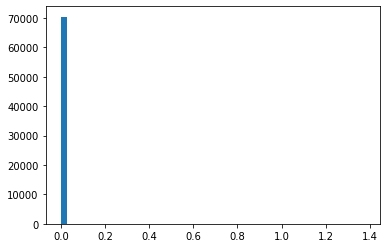

In [183]:
plt.hist(query_vec, bins=50)
plt.show()

In [181]:
def tfidf_transform(query: str, 
                    idf: np.ndarray, 
                    vocab2ix: Dict[str, int]) -> np.ndarray:
    # make tf
    query_tf = np.zeros((len(vocab2ix), ))
    for token in query.split():
        token_ix = vocab2ix[token]
        query_tf[token_ix] += 1
    query_tf = query_tf / sum(query_tf)
    
    # make tfidf
    query_tf = query_tf * idf
    
    return query_tf

In [182]:
query_vec = tfidf_transform(query, idf, vocab2ix)
query_vec

array([0., 0., 0., ..., 0., 0., 0.])

In [184]:
# найдем ближайший текст

def relevance_func(v1: np.ndarray, v2: np.ndarray) -> float:
    cossim = (v1 * v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return cossim.sum()

top_similar_texts = []
top_similar_scores = []
top_n = 5

for i, vec in tqdm(enumerate(tfidf_vectors), total=len(tfidf_vectors)):
    rel = relevance_func(query_vec, vec)
    if len(top_similar_scores) == 0 or top_similar_scores[-1] < rel:
        top_similar_scores.append(rel)
        top_similar_texts.append(texts[i])

    if len(top_similar_scores) > top_n:
        top_similar_scores = top_similar_scores[:top_n]
        top_similar_texts = top_similar_texts[:top_n]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:57<00:00, 1018.24it/s]


In [64]:
print(query)
print()

pairs = list(zip(top_similar_scores, top_similar_texts))

for rel, text in pairs[::-1]:
    print('%.3f   %s' % (rel, text))

microsoft start sale new window os

0.093   microsoft take sp sharer microsoft stop peopl get hold key secur updat via netbas file share system
0.091   googl ipo auction rocki start washingtonnew york reuter auction googl inc highli anticip initi public offer got rocki start friday web search compani sidestep bullet us secur regul
0.047   fed minut show dissent inflat usatodaycom usatodaycom retail sale bounc back bit juli new claim jobless benefit fell last week govern said thursday indic economi improv midsumm slump
0.018   oil price soar alltim record pose new menac us economi afp afp tearaway world oil price toppl record strain wallet present new econom menac bare three month us presidenti elect
0.000   wall st bear claw back black reuter reuter shortsel wall street dwindlingband ultracyn see green


### topic modelling

#### Latent Dirichlet Allocation

Это unsupervised модель, делящая корпус текстов на N тем. Верхнеуровнево её можно описать как 2 набора параметров:

   - alpha - вероятность каждого документа принадлежать каждому из топиков
   - beta - вероятность каждого слова принадлежать каждому из топиков
   
Модель случайно делит тексты на топики. Далее она с помощью град спуска настраивает alpha и beta. Так она увеличивает правдоподобие своей оценки

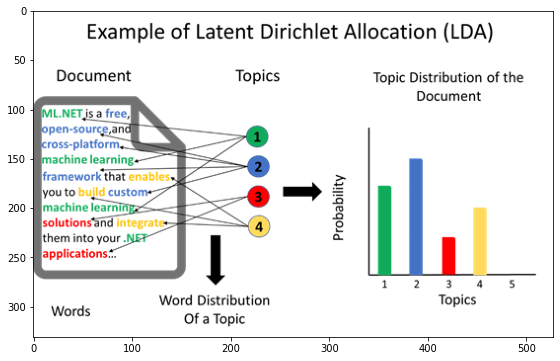

In [66]:
plt.figure(figsize=(10, 6))
plt.imshow(plt.imread('pics/lda.png'))

In [185]:
# проведем lda с помощью 

import gensim.corpora as corpora

id2word = corpora.Dictionary([text.split() for text in texts])
corpus = [id2word.doc2bow(text.split()) for text in texts]


print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2)]


In [186]:
import gensim

num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
for topic in lda_model.print_topics():
    print(topic)

(0, '0.007*"said" + 0.005*"reuter" + 0.005*"kill" + 0.005*"year" + 0.005*"two" + 0.005*"iraq" + 0.004*"ap" + 0.004*"nation" + 0.004*"compani" + 0.003*"first"')
(1, '0.010*"us" + 0.008*"new" + 0.006*"said" + 0.006*"reuter" + 0.005*"compani" + 0.005*"ap" + 0.004*"microsoft" + 0.004*"million" + 0.004*"secur" + 0.003*"world"')
(2, '0.007*"new" + 0.006*"ap" + 0.006*"said" + 0.005*"win" + 0.004*"reuter" + 0.004*"one" + 0.004*"world" + 0.004*"year" + 0.004*"game" + 0.003*"say"')
(3, '0.010*"us" + 0.010*"new" + 0.008*"reuter" + 0.008*"said" + 0.007*"ap" + 0.005*"oil" + 0.005*"stock" + 0.004*"report" + 0.004*"price" + 0.004*"game"')


#### visualize

In [82]:
# !pip install pyldavis

In [81]:
import pyLDAvis.gensim_models

import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is dep

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.030131  0.033000       1        1  26.958142
3      0.051765  0.014125       2        1  25.699191
2     -0.002618 -0.038603       3        1  24.638993
0     -0.019016 -0.008523       4        1  22.703674, topic_info=           Term          Freq         Total Category  logprob  loglift
43          oil   7411.000000   7411.000000  Default  30.0000  30.0000
106          ap  16719.000000  16719.000000  Default  29.0000  29.0000
429         win   6683.000000   6683.000000  Default  28.0000  28.0000
533   microsoft   5752.000000   5752.000000  Default  27.0000  27.0000
770        time   5510.000000   5510.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
118    thursday   1589.373240   7111.696309   Topic4  -6.0507  -0.0158
420       group   1450.308377   5190.863477   Topic4  -6.1423   0.2075
429         win   1499.525548   6683.208419   Topic4  -6.1089  -0.0118
1338     monday   1516.843184   7450.431230   Topic4  -6.0974  -0.1090
1104  wednesday   1469.596421   7458.273425   Topic4  -6.1291  -0.1417

[445 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
22139      3  0.926006     ababa
9847       1  0.800175      abba
9847       2  0.016905      abba
9847       3  0.174686      abba
9847       4  0.011270      abba
...      ...       ...       ...
6737       1  0.756988      yuko
6737       2  0.044240      yuko
6737       3  0.183103      yuko
6737       4  0.017204      yuko
30734      3  0.964730  zapatero

[1106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

### Word Embeddings

Рассмотрены на 9 лекции

## Deep learning embeddings

Сейчас лучший баланс между простотой применения и качеством имеют модели семейства BERT (Bidirectional Encoder Representations from Transformers)

### Теория на пальцах

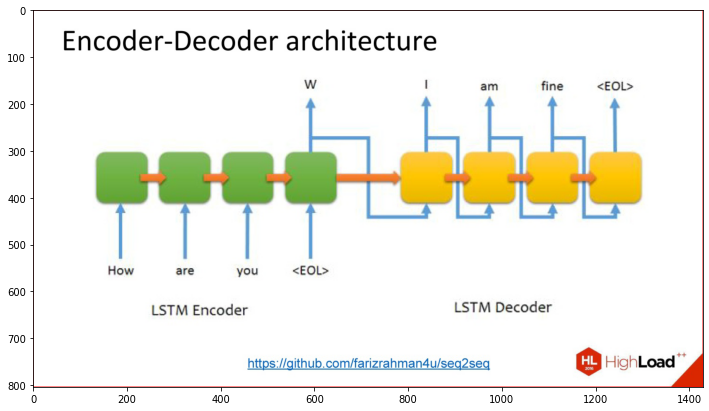

In [84]:
# Сначала про sequence to sequence нейросети
# Они позволяют обучать переводить одни последовательности в другие
# BERT тоже seq2seq модель

plt.figure(figsize=(12, 8))
plt.imshow(plt.imread('pics/seq2seq.png'))

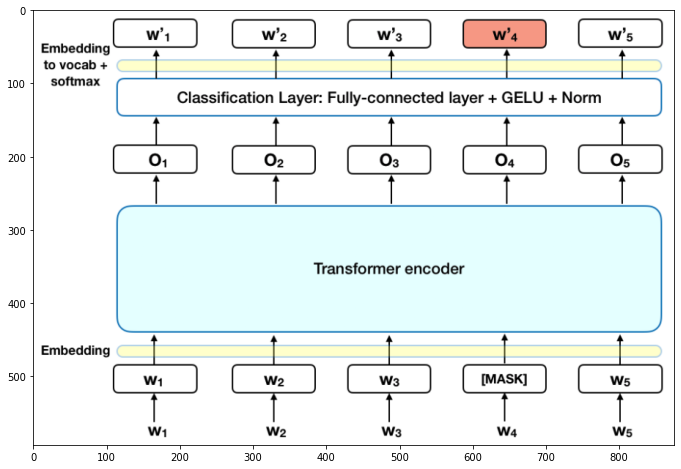

In [85]:
# Перейдем к архитектуре BERT
# Она состоит из получения эмбеддинга по слову, кодирование encoder'ами и предсказания слова из словаря

plt.figure(figsize=(12, 8))
plt.imshow(plt.imread('pics/bert-architecture.png'))

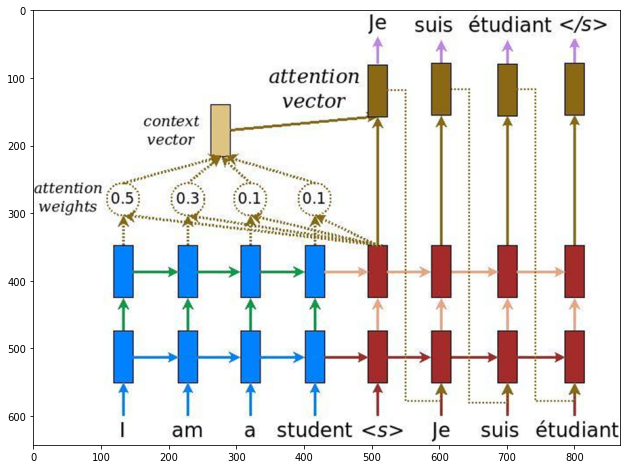

In [86]:
# Transformer encoder реализует механизм внимания (attention)
# Это позволяет модели понять, какие слова важны в этом контексе, а какие - нет


plt.figure(figsize=(12, 8))
plt.imshow(plt.imread('pics/attention-architecture.png'))

### Практика

In [188]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [190]:
print(query)
print(tokenizer.tokenize(query))
print(tokenizer.tokenize(query + ' and salling it well'))

microsoft start sale new window os
['microsoft', 'start', 'sale', 'new', 'window', 'os']
['microsoft', 'start', 'sale', 'new', 'window', 'os', 'and', 'sal', '##ling', 'it', 'well']


In [192]:
# Какие токены есть в словаре берта?
len(list(tokenizer.vocab.keys()))

30522

In [193]:
# Получим индексы токенов
tokenized_query = tokenizer.tokenize(query)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
indexed_tokens

[7513, 2707, 5096, 2047, 3332, 9808]

In [195]:
# модели нужны метки о принадлежности токена предложениям. Сейчас предложение одно

segments_ids = [1] * len(indexed_tokens)
segments_ids

[1, 1, 1, 1, 1, 1]

In [196]:
# convert to torch

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [197]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [198]:
outputs = model(tokens_tensor, segments_tensors)

embeddings = outputs[2]
[t.size() for t in embeddings]

[torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768]),
 torch.Size([1, 6, 768])]

In [199]:
print ("Слоёв:", len(embeddings), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Размер батча:", len(embeddings[layer_i]))
batch_i = 0

print ("Токенов:", len(embeddings[layer_i][batch_i]))
token_i = 0

print ("Размер эмбеддинга:", len(embeddings[layer_i][batch_i][token_i]))

Слоёв: 13   (initial embeddings + 12 BERT layers)
Размер батча: 1
Токенов: 6
Размер эмбеддинга: 768


In [200]:
last_layer_embs = embeddings[-1]
last_layer_embs.size()

torch.Size([1, 6, 768])

In [201]:
sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
sentense_embedding.size()

torch.Size([768])

#### Найдем похожие предложения

In [2]:
# incapsulate to function

def make_sentence_embedding(text: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model(tokens_tensor, segments_tensors)
    type(outputs)
    embeddings = outputs[2]
    last_layer_embs = embeddings[-1]
    sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return sentense_embedding

NameError: name 'torch' is not defined

In [203]:
query_emb = make_sentence_embedding(query)
query_emb.size()

torch.Size([768])

In [ ]:
texts_embs = []

for text in tqdm(texts):
    emb = make_sentence_embedding(text)
    texts_embs.append(emb)

In [204]:
len(texts_embs)

1695

In [207]:
texts_embs = torch.stack(texts_embs)

texts_embs.size()


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

(array([   0.,    0.,    0.,    0.,    0., 1695.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

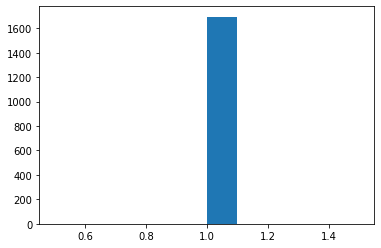

In [209]:
similarities = torch.nn.functional.cosine_similarity(query_emb, texts_embs)


plt.hist(similarities.detach().numpy())